# Convolutional Neural Networks

## Introduction
A neural network's hidden layers are used to learn feature detectors from input data. For simple input data types we can use fully connected hidden layers to allow us to learn features across any combination of input feature values. Thus one feature might be learned which is activated only when the first and last input feature values are both active. Another feature might be learned which is active when the average intensity across all input feature values is above a certain threshold. 

The figure below illustrates this situations. Here neurons $\delta^{2}_{1}$ and $\delta^{2}_{2}$ for example might be defined to depend on the first and last input neurons, and mean values of input neurons respectively.

<!-- conv-1.png --> 
<img width="300" src="https://drive.google.com/uc?id=1fMCHTOlnbr6_DegGJ4f11i6O4hzWuQQx"/>

While fully connected layers like this are very useful at learning features that might depend on any particular combination of input data values, they are computationally costly. The number of weights to be learned in a fully connected layer between input units $L1$ and hidden units $L2$ is: 

\begin{equation}
(size(L1)+1) \times size(L2)
\end{equation}

where the addition of 1 to the left hand side is due to the fact we need to learn the weight to a bias unit on the input layer. 

Lets consider for a moment the case of working with image data. Here if we assume a low resolution square image of edge 256 lines, and assume we want a hidden layer that can say pick out 64 features, then we require $((256 \times 256) + 1) \times 64$ weights, i.e., 4,194,368 weights. This is a very significant number of weights in comparison to the examples we have considered to date. 

For complex input data types such as images we deal with this exponential growth in the number of weights by taking advantage of specific properties of the input data. In the case of images we can take advantage of two facts:
1. That in images the input is often translation invariant; and
2. In early layers we can focus on learning local features rather than global features. 
 
To illustrate consider the case of analyising an image to find edges. An edge can be found by looking for a steep gradient in image pixel intensities in a local block of pixels. For example simple features for horizontal and vertical edge detection in a 3x3 block of pixels can be illustrated by the following weight matrices for linear feature detectors. 

<!-- edge-detector-unattributed.png --> 
<img width="300" src="https://drive.google.com/uc?id=1fUwg2t7-z65YLj8hDUd6hMZQ3_zzKnW3"/>


Such a local feature is translation invariant -- a horizontal edge at the bottom left of the picture generally looks like a horizontal edge in any other part of the image when viewed as a steep gradient in pixel intensities. Such a property has been taken advantage of in the image processing domain for many years. For example consider the image below where vertical and horizontal edges are extracted from an image. 

<!-- edges-unattributed.jpg --> 
<img width="500" src="https://drive.google.com/uc?id=1fYHuRLAdsMd1FjIw5Qbl1HJUGBqxf5b6"/>

We can illustrae the use of a simple edge detector below by scanning over an image from the MNIST dataset based on the Gx filter shown above. 

11493376/11490434 [==============================] - 0s 0us/step


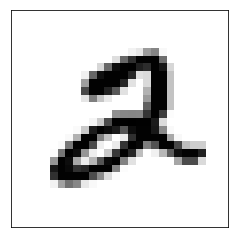

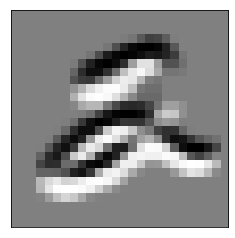

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mp
import numpy as np
import tensorflow as tf 

# Get a copy of the mnist dataset container 
mnist = tf.keras.datasets.mnist 

# Pull out the training and test data 
(x_train, y_train),(x_test, y_test) = mnist.load_data() 
image = x_train[5]

# Reshape the image into 2D and normalize pixel intensities to between 0 and 1
flattened_image = np.reshape(image, (-1, 28)) 
flattened_image = flattened_image / 255.

# For illustration purposes display the flattened image of a digit 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.matshow(flattened_image, cmap = mp.cm.binary)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.show()

# design a filter which picks out verticle edges
# in this case it is a 3x3 filter 
#weights = [-1,0,1,-1,0,1,-1,0,1]
weights = [-1,-1,-1,0,0,0,1,1,1]

# Construct a conainer for the result of filter application. 
# Note that our output image will be slightly smaller than our input image
num_rows, num_cols = np.ma.shape(flattened_image)
edge_output = np.zeros((num_rows-2,num_cols-2))

# iterate over the rows in the image and apply the filter
for i,row in enumerate(flattened_image):
    if i < (num_rows - 2):
        # iterate over each cell in the given row
        for j,val in enumerate(row):
            if j < (num_cols - 2):
                # manually isolate the pixels that will have the filter applied to
                sample = [flattened_image[i][j],
                          flattened_image[i][j+1],
                          flattened_image[i][j+2],                          
                          flattened_image[i+1][j],
                          flattened_image[i+1][j+1],
                          flattened_image[i+1][j+2],                            
                          flattened_image[i+2][j],
                          flattened_image[i+2][j+1],
                          flattened_image[i+2][j+2],                                                    
                         ]
                # calculate and store a logistic function based on the sample and weights
                logit = np.matmul(sample,weights)
                edge_output[i,j] = 1 / (1 + np.exp(-logit))

# for illustration purposes display the results of the feature detector 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.matshow(edge_output, cmap = mp.cm.binary)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.show()

In the example above we say that our filter is being *convolved* over the input image. In other words the filter is being applied independently to each input. 

Note that in the example code above we design our filter to only look at complete 3x3 blocks of our input image. This is a simplification to allow a quick and transparent implementation of the process. This results in our output image being slightly smaller than the input image. In this case our output image is 26x26 pixels rather than the 28x28 of our input image. 

It is also worth noting that the filters above have no bias value. This is acceptable in this simple case since we are not training the filter. However later when we switch to a Neural Network implementation we need to introduce a bias unit. 

## Convolutional Layer Design

In convolutional neural networks we apply the principle above to the design of hidden layers in the network. Specifically, instead of relying on neurons in a hidden layer that are fully connected to each neuron in the preceding layer, we instead design our hidden layer neurons in such a way that they are only exposed to a small sample of the input units. However we introduce clones of these neurons so that the entire set of inputs is covered by a given hidden layer neuron type. 

We can achieve this goal in a Deep Neural Network architecture by simultaneously learning copies of simple feature detectors that are applied across a complete input vector (2D in the case of images). Each of these detectors share the same weights and can thus be thought of as being copies or clones of each other. The features detected are local and assumed to be translational invariant. 

Rather than having a hidden layer that is fully connected to the input layer we end up with a hidden layer that consists of a set of neurons that each look at a slightly different subsample of the input image. The sub-sample might for example be a 3x3 grid of the input image. Each neuron in the convolutional neuron set is looking at a different part of the input, but crucially since all these neurons are forced to share the same weights, they all are looking for the exact same thing. 

This principle is illustrated in the figure below where the same feature detector is applied to different samples of the input image to generate a feature map. Note that the weight marked is fixed to the same value across each application. 

<!-- cnn-animated.gif --> 
<img width="300" src="https://drive.google.com/uc?id=1ezhdHl23eVafOshPStEO9QaCjG5ekwcf"/>

In a convolutional layer we typically train a number of these small local features. Each of these features in turn results in individual feature maps. Considering our example earlier we might for example construct a very simple convolutional layer with two features: one feature for vertical line detection and another feature for horizontal line detection. Such a simple convolutional layer is illustrated below. 

<!-- cnn_example.png --> 
<img width="300" src="https://drive.google.com/uc?id=1ezhdHl23eVafOshPStEO9QaCjG5ekwcf"/>

We see in this example that there are in fact two neuron types in our convolutional layer. Each of these is characterissed by having its own set of weights, but is applied iteratively over the input image to produce a given feature map. The feature itself is a simple 3x3 feature, i.e. it contains only 9 weights that are applied to a local block of the input. The feature results in a Feature Map over our input. The Feature Map is our resultant image above. 

### Convolutional Layer Parameters 

Looking again at the example we can see that a convolutional layer has 3 key parameters that describe the dimensionality of the layer's output. The first two of these are **width** and **height** and are used to describe the dimensionality of a given feature map in the convolutional layer. The third dimensionality feature is **depth**. Depth is the number of filter or neuron types in the convolution layer. Each index in the depth of the convolution layer allows another filter type / another feature type to be learned. All neurons at the same depth index share the same weights. 

The figure below shows a traditional illustration of one layer of a convolutional neural network. From this illustration we can see where the term depth has come to mean the number of features / feature maps in a convolutional layer. 

<!-- cnn_depth.png.png --> 
<img width="500" src="https://drive.google.com/uc?id=1f6Z_4-mEdP9WQz2kD5p3D7ao0hRXyKm9"/>

It should be noted however that CNNs are sometimes visualised as being orthogonal to our viewing plane. In this case the different feature types move from left to right across the screen as illustrated in this wikimedia image below. In that image the depth of the convolutional layer is 5 units and we see that all 5 units with the same height and width values are projections from the same scanned section of the input image. 

<!-- cnn_alt.png --> 
<img width="500" src="https://drive.google.com/uc?id=1f1CZyNB0-kGg12EPGcyNGkM_CbNG8lzo"/>

In our examples above our filter was applied with a sliding window of 1 over our input image. Thus the overlap between our application of the filters was maximized. It is possible to reduce this overlap and thus result in smaller convolutional feature maps. The amount of overlap is controlled by a parameter called **stride**. In our example above we used a stride of 1. A stride of 3 in the example above would result in no actual overlap of our filter over the input images. In our examples below we will stick with a stride of 1 for notational simplicity. 

### From One to Multiple Channels

In our mnist example, our input is a black and white image. We talk about this image type as just having one channel -- just black and white intensity. Colour images on the other hand are usually built around three individual maps of red, green, and blue intensities. Our feature based approach is easily expanded to deal with multiple channels. In such case the information from all 3 channels is accounted for in a single kernel computation. For example, in the example above we use a 3x3 filter applied to our 1 channel information. This results in 9 parameters to be trained (plus a single bias value). We can apply the same kernel type instead to 3 channel information. In this case the number of parameters that our kernel has to learn is (3 x 3 x 3) + 1, i.e., 28. A single feature detector will still produce a single image map. The advantage of this approach is that our filters not only get the opportunity to learn spatial features, but they can learn features dependent on particular combinations of colour. 

### Multiple Convolutional Layers

Rather than having a single convolutional layer in a network, we usually have a number of layers configured in a feedforward arrangement. Here a feature map at layer k with depth $d_{1}$ feeds can be used as input to any number of feature detectors in the next convolution layer. 

In a typical design, we treat all the image maps is a layer as individual channels being passed into the next layer. This gives our network the opportunity to combine information from multiple trained features. 


### Linking to Fully Connected Layers

Layers of convolutional neurons create more and more sophisticated feature detectors that operate locally. At a certain point we want to be able to investigate global connections in an image. For example we might want one feature that activates if a straight vertical line is detected in one area of an image and a horizontal line is detected to its upper right. For these global connections to be detected we need to once again introduce standard non-convolutional layers. 

<!-- cnn_full.png --> 
<img width="500" src="https://drive.google.com/uc?id=1fF3Uv8xwIelZXf9h45jHSx5VmhWY_SMy"/>


In the context of CNNs we refer to standard layers as fully connected layers. The reason for this is simply that all neurons in a standard layer are fully connected back to all units in the prior layer. Where the prior layer is a convolutional layer this means that all units in the convolution are connected. This can lead to an explosion of connections / weights. Consider the case where the convolutional layer has depth 20, height 20, and width 20. If our fully connected layer has say 30 neurons then we are talking about 240000 connections in one layer alone. 

## Pooling Layers

With a stride of 1 our convolutional feature maps are almost as big as our input images. With a potentially large number of features in our convolutional layer this can result in a very large number of output values which would then have to be fed into layers further down the network. To limit this growth in connection number we can subsample our convolutional feature maps to reduce their size. In neural network terminology this subsampling is referred to as pooling. 

We can illustrate this pooling method by applying a pooling layer to our image detection feature map as follows. 

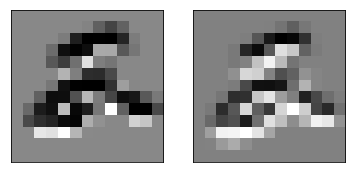

In [2]:
# Construct a conainer for the result of pooling application. 
num_rows, num_cols = np.ma.shape(edge_output)
mean_pool = np.zeros((num_rows//2,num_cols//2))
max_pool = np.zeros((num_rows//2,num_cols//2))

# iterate over the rows in the image and apply the filter
for i,row in enumerate(edge_output):
    if i % 2 == 0: 
        # iterate over each cell in the given row
        for j,val in enumerate(row):
            if j % 2 == 0: 
                # manually isolate the pixels that we will pool
                sample = [edge_output[i][j],
                          edge_output[i][j+1],                     
                          edge_output[i+1][j],
                          edge_output[i+1][j+1],                                                     
                         ]
                # store the pooled values
                mean_pool[i//2,j//2] = np.mean(sample)
                max_pool[i//2,j//2] = np.amax(sample)

# for illustration purposes display the results of the feature detector 
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.matshow(max_pool, cmap = mp.cm.binary)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
ax = fig.add_subplot(1, 2, 2)
ax.matshow(mean_pool, cmap = mp.cm.binary)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.show()

We pool by taking a clump of units and producing one aggregate value for those units. There are a number of ways in which we can aggregate or pool these values. One straightforward way is to simply calculate the mean activation over the clump of units. This is referred to as mean-pooling. Another popular method is to take the maximum value across the clump of units as the activation for the new aggregate unit. This is referred to as max-pooling. Max pooling rather than mean pooling has become the dominant method for pooling. One 'hand-waving' interpretation of why max-pooling might be most useful is that it preserves the identification of strong features rather than smoothing out the feature map. 

It is important to note that whereas a convolutional layer has an actual activation function which can be anything from a logistic function to RELU, a pooling layer does not apply any function to the input data apart from the pooling function itself (usually max or mean). 

The primary motivation for pooling is thus simply to reduce the size of feature maps and therefore reduce the number of connections in the network. Not only is this important in terms of reducing computational cost, but it also helps to reduce the potential for overfitting. 

The figure below illustrates the application of pooling in a complete workflow. 

<!-- cnn_pooling.png --> 
<img width="500" src="https://drive.google.com/uc?id=1fMBuHWsUWZYHxpre61DvPvQPLrALk5gs"/>



## Convolution and Pooling in Tensorflow 

TensorFlow provides a very neat implementation of Convolutional Neural Network and Pooling functionality where once again we just need to add in some extra layer definitions. 

### MNIST in TensorFlow without Convolution

To illustrate the TensorFlow approach we will swap over to the use of the MNIST digits corpus. In the code below we first provide an implementation without the use of convoutional or pooling layers. This implementation uses 2 hidden layers of 256 RELU units each. The Adam Optimzier is also used. This is basically the same examples we have seen a couple of times over the last few weeks. 

In [3]:
# import tensorflow library 
import tensorflow as tf 

# Get a copy of the mnist dataset container 
mnist = tf.keras.datasets.mnist 

# Pull out the training and test data 
(x_train, y_train),(x_test, y_test) = mnist.load_data() 

# Normalize the training and test datasets
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# Create a simple sequential network object
model = tf.keras.models.Sequential()

# Add layers to the network for processing the input data 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Start the training process
model.fit(x=x_train, y=y_train, epochs=5) 

model.summary()

# Evaluate the model performance with test data
test_loss, test_acc = model.evaluate(x=x_test, y=y_test,verbose=0)

# Print out the model accuracy 
print('\nTest accuracy: ' + str(test_acc*100) + "%" )

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4701 - accuracy: 0.8648
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1156 - accuracy: 0.9641
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0730 - accuracy: 0.9778
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0524 - accuracy: 0.9836
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0389 - accuracy: 0.9873
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (32, 784)                 0         
_________________________________________________________________
dense (Dense)                (32, 128)                 100480    
_________________________________________________________________
dense_1 (Dense)              (32, 128)                 16512     
_____________

The implementation above achieves very high accuracy in just 15 epochs. In fact we can see that the error even after completion of the 0th epoch is already down to below 20%. This isn't an error in the code, but is rather due to the use of mini-batch learning. In the code above we did not wait until collecting all of our error before making adjustments to our weights. Instead we split our training set into a number of mini-batches each of size 100. After collecting the errors for 100 examples we made adjustments to our weights. Given our training data size is very large, this means that we in fact make over 500 applications of the back-propagation of weights over every full epoch of training. Before proceeding, try adjusting the batch size and observer the error graph. 

With a batch size of 10000, how many epochs does it take for the error to reduce below 10%?

### MNIST in TensorFlow with Convolution

Implementing a convolutional layer in TensorFlow is very straightforward. We can take our MNIST code from above and very quickly update it to incorporate a CNN. We implement the major changes in our ff_network function. 

Note that we have to take our input images which had been flattened to 1D arrays and rework them into 2D for use with the convolutional layer. Similarly following the convolutional layer we also have to reshape the data back to 1D to feed it into a fully-connected layer. 

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

input_shape = (28, 28, 1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

# Start the training process
model.fit(x=x_train, y=y_train, epochs=5) 

# Evaluate the model performance with test data
test_loss, test_acc = model.evaluate(x=x_test, y=y_test,verbose=0)

# Print out the model accuracy 
print('\nTest accuracy: ' + str(test_acc*100) + "%" )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 12)        120       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2028)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                32464     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 32,754
Trainable params: 32,754
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 18s 9ms/step - loss: 0.6760 - accuracy: 0.7947
Epoch 2/5
1875

## Skip Connections & Residual Networks 

CNNs allow us to build networks that can build general purpose feature detectors that can be applied over an entire image but yet only require a relatively small number of weights. This versatility lead to many different network architectures being developed around the basic CNN architecture over the last 10 years. However it is important to note that deeper and deeper networks with 50+ layers were often found to be very useful as they could detect more and more complex features from fed in image data. However it was equally found that well known challenges in building deeper and deeper networks were seen. These problems such as the 'vanishing gradient' problem limited the depth of Deep Learning networks in general and deep CNN networks in particular. 

The so-called Skip Connection provided an essential next step in the development of very deep CNN based networks. The basic idea of the skip connection is that instead of having simply a single collection of neurons in a given hidden layer, that we instead build a special layer type that includes a typical layer architecture but also a specialist direct link between inputs and outputs that allowed signal to fully flow from inputs to outputs without the alteration caused by the activation function. These so-called skip connections have become an integral part of so-called Residual Networks and underpin the standard Deep CNN architectures at this point. 

The figure below illustrates the general layout of a skip connection as used in a residual network. 

<!-- cnn_pooling.png --> 
<img width="500" src="https://drive.google.com/uc?id=18ShyNnJtXKoG32xmOeGT28ZvjFlkWxT2"/>

The top of the image shows an extract from two standard layers of a network. Here we have an input x. For the moment we can assume this is either directly from an actual input, or perhaps is an output from another hidden layer that is not shown. In a normal way, that value x passes through two hidden layers in sequence. In each layer we first of all compute the value z from x and the weights, before passing this value, the logit, on to the unit's activiation function. Here we assume the activation function is the Rectified Linear Unit. The output of this unit is then passed forward as input to the next unit which in turn calculates the logit with its own weights before again calculating the activation function. This second activtion function can be thought of as the output of this extract, or block. 

In the bottom of the image we show the altered form as used in a residual network. Again we have an input x, but in this case as well as being passed into the first unit, it is also copied around the first hidden unit and fed into the second unit directly. When it is fed into the second unit, it is important to note that the input is not fed into the unit's standard inputs before calculation of the logit. Instead it is added to the output of the logit calculation just before the calculation of the activation function. 

While this explains the mechanism of what a skip connection is, it says little to us about the intuition of why this would work. In short, the intuition is that in backpropogation the skip connection is allowing more of the error signal to continue to backpropogate through the network than would be possible otherwise. The two RELU functions can still learn complex functions, but importantly we can now build longer deeper networks. 

It should be noted that this is just one example of what a residual block can look like. There are many more variations of this general theme. 

## The Inception Networks

While residual blocks solve many of the challenges in deep CNNs, they are not the end of the story. Making image classifiers more generic required a numbe of other engineering tricks that increased performance. The Incpetion Networks lead the way in many of these changes. 

One of the most important changes introduced by the Inception Network concerned the issue of scale. 

The core of the CNN is the feature kernel. In the examples above we suggested that feature kernels of size 3, 4, or 5 might be useful for image processing. In practice however different kernel sizes are better for different object analysis types. For example small kernels are good at identifying small patterns in data, where large kernels are better at identifying more global information. The most important contribution of the inception networks was the idea of having kernels of different sizes within the same layer of the network. This allowed the network to be far more scale invariant in training than was possible previously. 

<!-- cnn_pooling.png --> 
<img width="500" src="https://drive.google.com/uc?id=19lb9lUilT0dzLJ4VXvO9P0BcNwo_umub"/>

The figure above from Inception Network v1 illustrates how multiple different convolution filter sizes were used in a typical layer alongside max pooling layers to provide a more complex or rather wider range of analysis than was possible previously. 

Inception introduced many other useful improvements that are beyond of what we can cover here. For anyone interested, a good blog review of the inception network versions and their individual improvements can be found here: 

https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202#:~:text=The%20Inception%20network%20was%20an,Designing%20CNNs%20in%20a%20nutshell.


## CIFAR 10 Tutorial

The TensorFlow Website has a number of excellent tutorials which demonstrate the power of TensorFlow. CIFAR 10 is a basic dataset for image classification which is often used as a next step after MNIST classification. 

Read, study and put to work the TensorFlow CIFAR 10 Tutorial as described here:
https://www.tensorflow.org/tutorials/images/cnn

In order to get your code to run on non GPU hardware it may be necessary for you to reduce the complexity of the network, or only training for a shorter period of time than would be possible. 


## Suggested Tasks

1. Add a second CNN layer to the MNIST example above. How does performance and training compare to the 1 CNN variant?
2. Add dropout to the MNIST example. Once again, how does training speed and accuracy compare to the original variant? 
3. Integrate the CIFAR-10 dataset into the MNIST example above. 